<a href="https://colab.research.google.com/github/RF-Lab/lab_sources/blob/master/notebooks/berry_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import requests, zipfile, io

#url = 'https://github.com/RF-Lab/lab_sources/blob/master/notebooks/dataset.zip?raw=true'
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('/tmp/')
z.close()

#base_dir = '/tmp/dataset'
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')



Found 2000 images belonging to 2 classes.
[1. 0.]


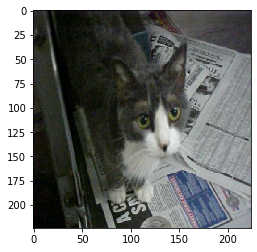

[1. 0.]


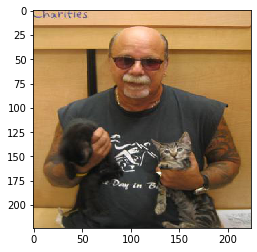

[1. 0.]


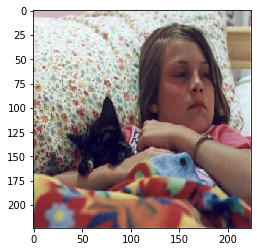

[0 0 0 ... 1 1 1]
Original VGG16 model

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooli

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical
import matplotlib.pyplot as plt

train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    )

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

train_labels = train_generator.labels
print(train_labels)

model = VGG16(weights='imagenet')
print('Original VGG16 model\n')
model.summary()
model = Model(inputs=model.input, outputs=model.get_layer('fc1').output)
print('VGG16 model w/o softmax\n')
model.summary()

print('Get VGG fc2 inference\n')
smax_train_data = model.predict_generator(train_generator)
print('Completed\n')

smax_model = Sequential()
smax_model.add(Dense(4096, input_dim=4096))
smax_model.add(Dropout(0.5))
smax_model.add(Activation('relu'))
smax_model.add(Dense(2, input_dim=4096))
smax_model.add(Dropout(0.5))
smax_model.add(Activation('softmax'))
smax_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_labels = to_categorical(train_labels)
smax_model.fit(smax_train_data, train_labels, epochs=5)

validate_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    )

validate_generator = validate_datagen.flow_from_directory(
        validation_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validate_labels = validate_generator.labels
validate_labels = to_categorical(validate_labels)
print(validate_labels)

smax_validate_data = model.predict_generator(validate_generator)

test_loss, test_acc = smax_model.evaluate(smax_validate_data,  validate_labels, verbose=2)
print('\nTest accuracy:', test_acc)